# Test for a common fit of Doppler and range data lags

Based on the comprehensive separate tests of Doppler and range data,
only lags without the station acceleration component are tested below.
The alternative lags are still computed, to facilitate quick retesting with them in the notebook.


In [1]:
from astropy import units as u
sampling_interval = 1*u.hour
tracking_period = 30*u.day

In [2]:
from astropy import constants as const
from astropy import visualization
from astropy.coordinates import solar_system_ephemeris

from poliastro.util import norm
from poliastro.twobody.sampling import EpochsArray

import numpy as np
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import orbit_from_horizons, make_epochs, find_rates
from sim.util import describe_orbit, describe_trajectory, plot_residual, plot_swings
from sim.fitorbit import OrbitFitter

def plots(epochs, residual, title, ylab):
    plot_residual(epochs, residual, title, 'Residual ' + ylab)
    try:
        plot_swings(epochs, residual, None, 'Residual swings ' + ylab)
    except ValueError:
        # no swings identified
        pass

def fitv(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, trace=_trace)
    fitter.fit_doppler_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)
    plots(epochs, fitter.result.residual, title, 'doppler (m/s)')
    return fitter

def reusefitv(fitsolution, epochs, sim_meas, title):
    residual = fitsolution.doppler_residual(epochs, sim_meas)
    plots(epochs, residual, title, 'doppler (m/s)')
    return residual

def fitr(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, trace=_trace)
    fitter.fit_range_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)
    plots(epochs, fitter.result.residual, title, 'range (m)')
    rates = find_rates(epochs, fitter.result.residual)
    plots(epochs[1:], rates, None, 'range rate (m/s)')
    return fitter, rates

def reusefitr(fitsolution, epochs, sim_meas, title):
    residual = fitsolution.range_residual(epochs, sim_meas)
    plots(epochs, residual, title, 'range (m)')
    rates = find_rates(epochs, residual)
    plots(epochs[11:], rates[10:], None, 'range rate (m/s)')
    return rates

In [3]:
solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value

near_goldstone_orbit = orbit_from_horizons("NEAR", goldstone_end)
describe_orbit(near_goldstone_orbit)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
canberra_start = Tracking.NEAR_CANBERRA_START.value
canberra_end = canberra_start + tracking_period
epochs = make_epochs(canberra_start, canberra_end, sampling_interval)
print("Start and end:", epochs[0], epochs[-1], "[", epochs.size, "]")

near_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(epochs))
describe_trajectory(near_extended_ephem, dss34)

Start and end: 1998-01-23 09:53:55.600 1998-02-22 08:53:55.600 [ 720 ]

::TRAJECTORY::
Start and end ranges: 99245.7532096098 km 17847093.095720734 km
Start and end radial speeds: 7.3216176182785535 km / s 6.742051287016325 km / s
Closest: 73145.82143191747 km speed 7.5891622264313146 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.457927625040083 deg


In [5]:
vdata_ref = []
vlags = []
vlags_full = []
vdata_constvlags = []
vdata_ltlags_full = []
vdata_ltlags = []
vdata_scaledlags = []

rdata_ref = []
rlags = []
rlags_full = []
rdata_constrlags = []
rdata_ltlags_full = []
rdata_ltlags = []
rdata_scaledlags = []

scalefactor = 0.1
first_vlag = None
first_rlag = None

for e in epochs[:-1]:
    ref_r, ref_rr, ref_ra, ref_rs = dss34.range_rate_accel(near_extended_ephem, e)
    print(e.strftime("%H:%M:%S"),
         ref_r.to_value(u.km),
         ref_ra.to_value(u.m/(u.s*u.s)),
         ref_rs.to_value(u.m/(u.s*u.s)),
         (ref_ra+ref_rs).to_value(u.m/(u.s*u.s)),
         )

    vlag_full = ref_ra*ref_r/const.c
    vlag = (ref_ra+ref_rs)*ref_r/const.c

    if first_vlag is None:
        first_vlag = vlag

    vlags.append(vlag)
    vlags_full.append(vlag_full)

    vdata_ref.append([ref_rr])
    vdata_constvlags.append([ref_rr - first_vlag])
    vdata_ltlags_full.append([ref_rr - vlag_full])
    vdata_ltlags.append([ref_rr - vlag])
    vdata_scaledlags.append([ref_rr - scalefactor*vlag])

for e in epochs:
    rv = near_extended_ephem.rv(e)
    ref_r, ref_rr, ref_rs = dss34.range_and_rates(rv, e)
    print(e.strftime("%H:%M:%S"),
         ref_r.to_value(u.km),
         ref_rr.to_value(u.m/u.s),
         ref_rs.to_value(u.m/u.s),
         (ref_rr+ref_rs).to_value(u.m/u.s),
         )

    rlag_full = ref_rr*ref_r/const.c
    rlag = (ref_rr+ref_rs)*ref_r/const.c

    if first_rlag is None:
        first_rlag = rlag

    rlags.append(rlag)
    rlags_full.append(rlag_full)

    rdata_ref.append([ref_r])
    rdata_constrlags.append([ref_r - first_rlag])
    rdata_ltlags_full.append([ref_r - rlag_full])
    rdata_ltlags.append([ref_r - rlag])
    rdata_scaledlags.append([ref_r - scalefactor*rlag])

09:53:55 73145.82143191747 -0.04185589375538257 0.01192843359500273 -0.029927460160379837
10:53:55 99245.7532096098 -0.03059583885089978 0.00693192085350347 -0.02366391799739631
11:53:55 124953.15770282669 -0.019042220756659844 0.003217205848670801 -0.015825014907989043
12:53:55 150407.26865298714 -0.011860758101001068 2.649666981824339e-06 -0.011858108434019243
13:53:55 175706.3273609694 -0.0061811455198679255 -0.002839522583883536 -0.009020668103751461
14:53:55 200923.61747138412 -0.0019067205281331212 -0.0052638765777146546 -0.007170597105847777
15:53:55 226115.081514972 0.0013292310754309256 -0.00718074742607655 -0.005851516350645625
16:53:55 251322.7147374973 0.0036045875928536475 -0.008504513680904324 -0.004899926088050678
17:53:55 276576.09410904173 0.004988653794057996 -0.00917620543836506 -0.004187551644307065
18:53:55 301893.2139723953 0.005533782702293877 -0.009174524770680037 -0.003640742068386161
19:53:55 327281.2187505763 0.005310967222449392 -0.008520129656403697 -0.0032

11:53:55 2515661.648220473 -4.8158355525629304e-05 -1.277645012009998e-05 -6.0934805645729284e-05
12:53:55 2539985.1927569434 0.002186865988740294 -0.0022453042786736432 -5.8438289933349016e-05
13:53:55 2564336.9087671335 0.00426831548594464 -0.004324525698351067 -5.62102124064265e-05
14:53:55 2588743.617146506 0.006053082967305556 -0.006107401231503218 -5.431826419766173e-05
15:53:55 2613228.315979765 0.007418314467599885 -0.007471117123252213 -5.28026556523286e-05
16:53:55 2637808.5975996307 0.008269981785602454 -0.008321655777510983 -5.1673991908530144e-05
17:53:55 2662495.4370598304 0.008549464323159839 -0.008600378944833231 -5.0914621673392256e-05
18:53:55 2687292.436792106 0.008237652638243276 -0.008288135473264902 -5.0482835021626736e-05
19:53:55 2712195.580307736 0.007356269764002832 -0.007406588795667801 -5.031903166496943e-05
20:53:55 2737193.511970566 0.00596631707683315 -0.006016669686204068 -5.0352609370918175e-05
21:53:55 2762268.322841211 0.004163768865694806 -0.00421427

15:53:55 4986052.574609269 0.007745054791286066 -0.00775964581821853 -1.4591026932464786e-05
16:53:55 5010625.97981381 0.008432408216130227 -0.008446828292861142 -1.4420076730914687e-05
17:53:55 5035308.040193997 0.008540180601812608 -0.008554525763056375 -1.4345161243767442e-05
18:53:55 5060100.145541057 0.00806099703698493 -0.008075353425510912 -1.4356388525982053e-05
19:53:55 5084996.122432971 0.007027857077623878 -0.007042295747382354 -1.4438669758476293e-05
20:53:55 5109982.659340616 0.005511834813454186 -0.005526408292837459 -1.4573479383272957e-05
21:53:55 5135040.222336366 0.0036171408552831963 -0.00363188137359316 -1.4740518309963513e-05
22:53:55 5160144.39777782 0.0014739026283905332 -0.0014888217918809232 -1.4919163490389948e-05
23:53:55 5185267.568987766 -0.0007708214422308401 0.0007557319204352098 -1.5089521795630403e-05
00:53:55 5210380.811142196 -0.002963160287805522 0.0029479271146470865 -1.5233173158435217e-05
01:53:55 5235455.874003927 -0.004952977450400908 0.00493764

19:53:55 7455737.157660354 0.006663942937912282 -0.006670700153364351 -6.757215452069105e-06
20:53:55 7480732.088495608 0.005034913437285127 -0.005041758186251855 -6.8447489667278e-06
21:53:55 7505791.9007513635 0.0030604987761861935 -0.0030674444014096025 -6.945625223409285e-06
22:53:55 7530891.1533279605 0.0008761670464707549 -0.0008832173727739701 -7.050326303215155e-06
23:53:55 7556001.699847601 -0.001368306663529495 0.0013611570393834427 -7.149624146052323e-06
00:53:55 7581094.618578561 -0.00351912536888932 0.0035118904559254815 -7.234912963838073e-06
01:53:55 7606142.19422557 -0.005429004313661778 0.005421705826307743 -7.298487354034397e-06
02:53:55 7631119.815856553 -0.006967233884935808 0.006959900116157769 -7.333768778039159e-06
03:53:55 7656007.661286411 -0.008028590028352767 0.008021254404567912 -7.335623784854021e-06
04:53:55 7680792.05306519 -0.008540494202513571 0.00853319347898207 -7.3007235315005695e-06
05:53:55 7705466.39382493 -0.008467945808554589 0.00846071788292235

00:53:55 9950935.222310018 -0.004054212780602029 0.004049993190150758 -4.219590451271218e-06
01:53:55 9975959.7770295 -0.00587646377425699 0.005872204288309035 -4.259485947954803e-06
02:53:55 10000908.611826109 -0.007296284953994814 0.007292002804788922 -4.282149205892159e-06
03:53:55 10025763.430278469 -0.008216524234327949 0.008212239502434215 -4.284731893733148e-06
04:53:55 10050512.37335519 -0.008574228342439483 0.008569962877531534 -4.265464907948362e-06
05:53:55 10075150.830691164 -0.0083449285011028 0.00834070457835523 -4.22392274757101e-06
06:53:55 10099681.755972002 -0.007544306068751894 0.007540144878831256 -4.161189920637176e-06
07:53:55 10124115.464938639 -0.006227126931435123 0.006223046974668023 -4.079956767100374e-06
08:53:55 10148468.929712012 -0.004483515073872013 0.004479530629538431 -3.984444333582102e-06
09:53:55 10172764.617511813 -0.002432813530184319 0.0024289333616565045 -3.88016852781432e-06
10:53:55 10197028.952823078 -0.00021544340444989984 0.0002116699179168

03:53:55 12395025.508214217 -0.008365451551028968 0.008362645285579617 -2.806265449350516e-06
04:53:55 12419741.338818917 -0.008568293242916525 0.008565500635771883 -2.792607144642067e-06
05:53:55 12444346.760028085 -0.008184406774525144 0.008181642411571488 -2.7643629536560786e-06
06:53:55 12468846.717507739 -0.007240056848267784 0.007237334382523386 -2.7224657443976032e-06
07:53:55 12493253.379044907 -0.005799864315036984 0.005797195403857813 -2.668911179170739e-06
08:53:55 12517585.301907348 -0.003962402356449957 0.003959795672670907 -2.606683779049639e-06
09:53:55 12541866.1626653 -0.0018534725700902754 0.001850933002799593 -2.5395672906824764e-06
10:53:55 12566123.136155244 0.00038248658551509607 -0.000384958410805325 -2.471825290228955e-06
11:53:55 12590385.034298064 0.0025922779558484876 -0.002594685795642704 -2.407839794216131e-06
12:53:55 12614680.332029227 0.004624438811440257 -0.004626790475242615 -2.351663802357745e-06
13:53:55 12639035.215590475 0.006339630932217233 -0.006

07:53:55 14862076.446707975 -0.005347141867950711 0.005345264103397085 -1.8777645536259782e-06
08:53:55 14886389.78569529 -0.003424960334008631 0.00342312659347499 -1.8337405336410518e-06
09:53:55 14910658.987853255 -0.0012680905463469117 0.0012663036062292576 -1.7869401176539174e-06
10:53:55 14934911.845807875 0.000975723932761241 -0.0009774643621511814 -1.7404293899404404e-06
11:53:55 14959177.272752805 0.0031527339485748485 -0.0031544312296034605 -1.6972810286120372e-06
12:53:55 14983483.321273107 0.005113719700133856 -0.005115379983763546 -1.660283629689743e-06
13:53:55 15007855.260551859 0.006724228355459161 -0.00672586004088771 -1.6316854285492984e-06
14:53:55 15032313.843807248 0.00787380938138682 -0.007875422372322305 -1.612990935484382e-06
15:53:55 15056873.88506088 0.008483608682219312 -0.008485213556493676 -1.6048742743630901e-06
16:53:55 15081543.242978968 0.00851179425165327 -0.008513401419442346 -1.6071677890759547e-06
17:53:55 15106322.281821346 0.007956435482014967 -0.0

12:53:55 17352076.80688347 0.005577232212949923 -0.005578465471359095 -1.2332584091722136e-06
13:53:55 17376467.91330203 0.0070756403820482205 -0.007076854652765974 -1.2142707177532469e-06
14:53:55 17400950.19215392 0.008089062490945764 -0.008090265339603775 -1.2028486580101786e-06
15:53:55 17425536.703016803 0.008547992184304576 -0.008549191526126876 -1.199341822300567e-06
16:53:55 17450233.360523112 0.008420951932208709 -0.008422155420010569 -1.2034878018603963e-06
17:53:55 17475038.528720498 0.007716658377177055 -0.007717872862372133 -1.2144851950776295e-06
18:53:55 17499943.13331726 0.006483422019698537 -0.006484653137320606 -1.2311176220696724e-06
19:53:55 17524931.284124833 0.004805823240694451 -0.004807075120282889 -1.2518795884379456e-06
20:53:55 17549981.364826657 0.0027988961033287296 -0.0028001712064593676 -1.275103130638202e-06
21:53:55 17575067.515200403 0.0006002240260372105 -0.0006015231043221547 -1.2990782849442482e-06
22:53:55 17600161.403989863 -0.0016395050952411339 

22:53:55 2787396.7871512296 6985.1473182299005 -114.13921799008092 6871.00810023982
23:53:55 2812551.9627528093 6988.6073814314495 -117.78219187115074 6870.825189560298
00:53:55 2837705.044099516 6983.989185094649 -113.3474312041555 6870.641753890494
01:53:55 2862827.339612924 6971.601126391596 -101.14293417195657 6870.458192219639
02:53:55 2887892.2376337647 6952.283531735762 -82.00845361507196 6870.2750781206905
03:53:55 2912877.0268648346 6927.350403389809 -57.257281117976504 6870.093122271833
04:53:55 2937764.4478836968 6898.49914315001 -28.586012847538935 6869.9131303024715
05:53:55 2962543.871071633 6867.694469092313 2.041485772566859 6869.73595486488
06:53:55 2987212.021779326 6837.034384563155 32.52805711276492 6869.56244167592
07:53:55 3011773.2040457963 6808.607192530815 60.786178500423944 6869.393371031239
08:53:55 3036239.0077683222 6784.3491198800775 84.88027855722119 6869.229398437298
09:53:55 3060627.518794583 6765.912096005066 103.15890386697168 6869.070999872039
10:53:

02:53:55 5260467.116596762 6936.6104572707945 -75.35811954284388 6861.252337727951
03:53:55 5285393.261683401 6910.527313198868 -49.33031147378663 6861.1970017250815
04:53:55 5310218.850605812 6881.0664091175995 -19.924521822146954 6861.141887295453
05:53:55 5334935.299733168 6850.241916952403 10.845354375034168 6861.087271327437
06:53:55 5359541.486923974 6820.161179309915 40.872252435117446 6861.0334317450315
07:53:55 5384043.828301918 6792.88077580987 68.09985260988718 6860.980628419757
08:53:55 5408455.840097473 6770.266007957692 90.66307549849144 6860.9290834561825
09:53:55 5432797.215155585 6753.863316912653 107.01564585922821 6860.878962771882
10:53:55 5457092.476623639 6744.794310972187 116.03605022041741 6860.830361192605
11:53:55 5481369.300187828 6743.678664863317 117.1046282923488 6860.783293155667
12:53:55 5505656.61907488 6750.591240121938 110.14645041807492 6860.737690540013
13:53:55 5529982.641224597 6765.056478397225 95.63692981605789 6860.693408213283
14:53:55 5554372

23:53:55 8741008.742499009 6972.2510639316315 -115.38278588388182 6856.868278047749
00:53:55 8766093.380950227 6962.381778131217 -105.53291215906366 6856.848865972153
01:53:55 8791129.19495282 6945.28225523295 -88.45301357578563 6856.829241657165
02:53:55 8816092.125180159 6922.12344047749 -65.31396581017223 6856.809474667317
03:53:55 8840963.102770455 6894.490919913309 -37.70126971338062 6856.7896501999285
04:53:55 8865729.353992643 6864.276313145154 -7.506448502557999 6856.769864642596
05:53:55 8890385.273970105 6833.547837579248 23.202382495947287 6856.750220075195
06:53:55 8914932.810011888 6804.408861727511 52.32195604559882 6856.73081777311
07:53:55 8939381.328489361 6778.854064391552 77.85768662748288 6856.711751019036
08:53:55 8963746.9742793 6758.63297730071 98.06012049421217 6856.693097794922
09:53:55 8988051.566308193 6745.1302007616005 111.54471336347706 6856.6749141250775
10:53:55 9012321.1043923 6739.270473611765 117.38675530019066 6856.657228911956
11:53:55 9036583.98913

04:53:55 11235175.116740242 6854.696166254387 0.6943841845540181 6855.39055043894
05:53:55 11259796.795498254 6824.198569353169 31.17974896611987 6855.378318319289
06:53:55 11284311.915316941 6795.836887163992 59.52935117333907 6855.366238337331
07:53:55 11308731.725802574 6771.55319442979 83.8011729362006 6855.3543673659915
08:53:55 11333074.003262205 6753.010524588478 102.3322271956543 6855.342751784132
09:53:55 11357361.834144762 6741.478964689484 113.85245874317606 6855.331423432661
10:53:55 11381622.03462008 6737.7485550111205 117.57184160604824 6855.320396617169
11:53:55 11405883.314112073 6742.074981158163 113.23468544350123 6855.309666601664
12:53:55 11430174.308368864 6754.161826791506 101.1373830668191 6855.299209858325
13:53:55 11454521.6167814 6773.1806646261475 82.10832146949078 6855.288986095638
14:53:55 11478947.978505548 6797.827668653338 57.45127317810299 6855.2789418314405
15:53:55 11503470.71278441 6826.412910036174 28.856105026010194 6855.269015062184
16:53:55 11528

00:53:55 14689297.316143965 6949.115763079491 -94.93780475327881 6854.177958326212
01:53:55 14714277.633726595 6927.863500534831 -73.69260743544892 6854.170893099382
02:53:55 14739171.861352075 6901.562900808538 -47.399121563841895 6854.163779244696
03:53:55 14763964.981292883 6872.015378545518 -17.858728521625068 6854.156650023893
04:53:55 14788648.900716854 6841.24458034418 12.9049614399166 6854.149541784096
05:53:55 14813223.005578613 6811.357873634323 42.78461811577552 6854.142491750099
06:53:55 14837694.202609641 6784.402125031777 69.73341045493463 6854.135535486711
07:53:55 14862076.446707975 6762.223602121333 91.90510208253862 6854.128704203871
08:53:55 14886389.78569529 6746.341556258949 107.78046590506705 6854.122022164017
09:53:55 14910658.987853255 6737.844124036284 116.27138046270105 6854.115504498984
10:53:55 14934911.845807875 6737.3136798199885 116.79547591503437 6854.109155735023
11:53:55 14959177.272752805 6744.786777918158 109.31619133612354 6854.102969254282
12:53:55

05:53:55 17181872.789099496 6803.3528037938 50.24953937554699 6853.6023431693475
06:53:55 17206316.993952334 6777.491589851003 76.10559777024851 6853.597187621251
07:53:55 17230676.999514196 6756.84428816817 96.74783979312888 6853.592127961299
08:53:55 17254974.245148737 6742.825410981217 110.76176977081933 6853.587180752036
09:53:55 17279234.470202036 6736.395555847717 117.1867995837265 6853.582355431444
10:53:55 17303485.951060366 6737.995492198621 115.58216116860778 6853.57765336723
11:53:55 17327757.564104248 6747.515818159251 106.05724947924644 6853.5730676384965
12:53:55 17352076.80688347 6764.304304991621 89.26427860791145 6853.568583599534
13:53:55 17376467.91330203 6787.210466970013 66.35371319875263 6853.564180168765
14:53:55 17400950.19215392 6814.664335562779 38.89549612006165 6853.559831682841
15:53:55 17425536.703016803 6844.784056023349 8.771454059462332 6853.555510082811
16:53:55 17450233.360523112 6875.504928261781 -21.95374109128134 6853.5511871705
17:53:55 17475038.5

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 719
    # variables        = 6
    chi-square         = 1.8991e-04
    reduced chi-square = 2.6635e-07
    Akaike info crit   = -10878.5773
    Bayesian info crit = -10851.1101
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83945089 (init = -1.839425)
    raan:  1.54004127 (init = 1.540059)
    argp:  2.53325285 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:48.678306

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[0.000

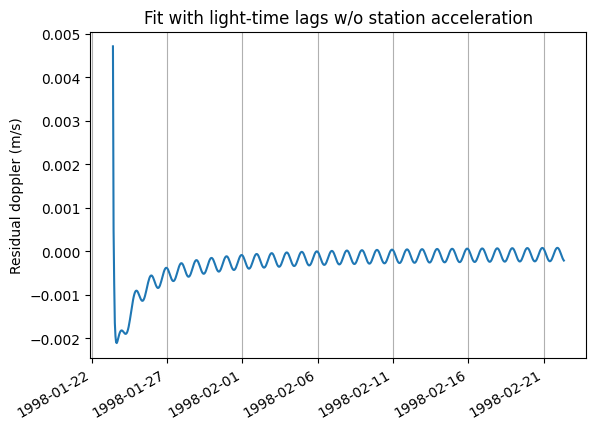

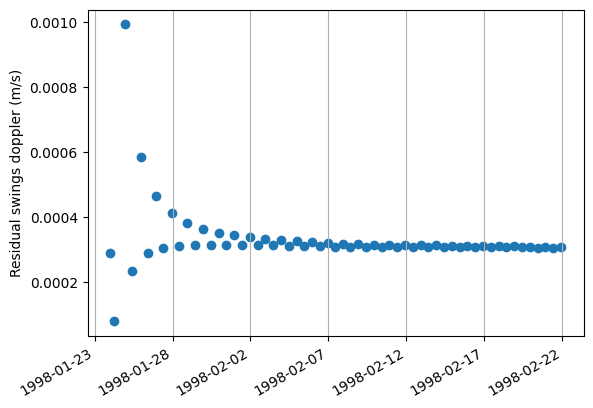

In [6]:
ltfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_ltlags, "Fit with light-time lags w/o station acceleration")

[0.0028285472136405504, 0.0028266812053820145, 0.002828022051188747, 0.0028248508978221815]


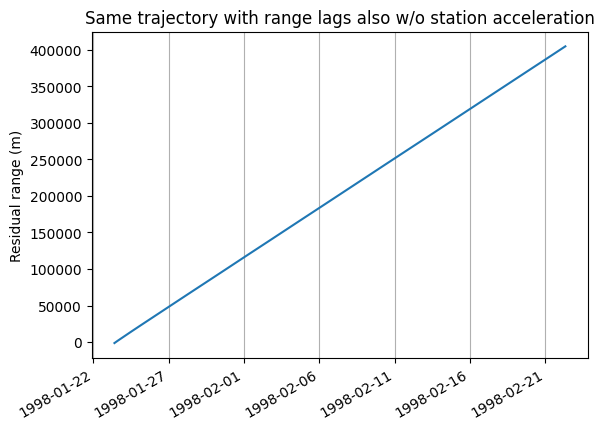

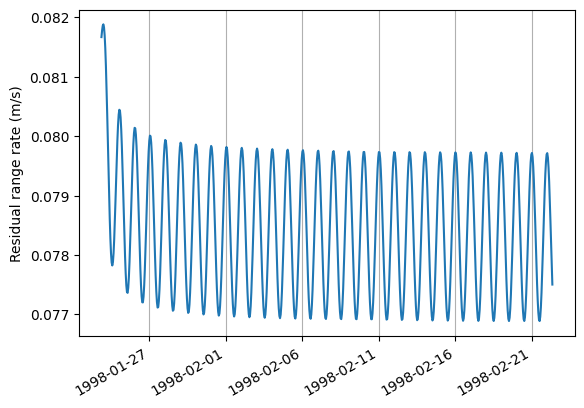

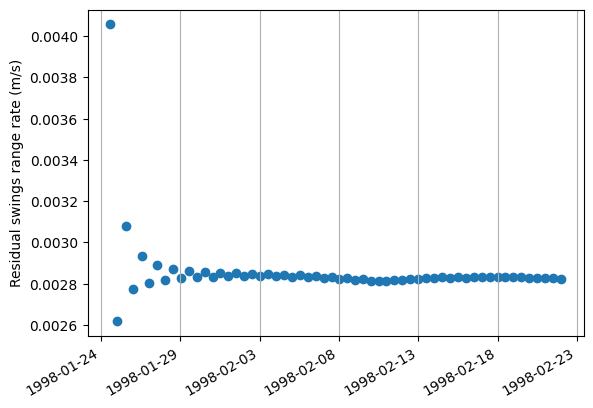

In [7]:
_ = ltresr_rates = reusefitr(ltfitv, epochs[:-1], rdata_ltlags, "Same trajectory with range lags also w/o station acceleration")

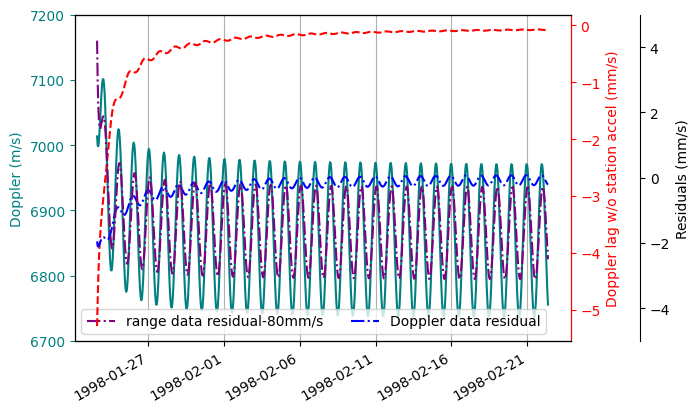

In [8]:
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('')
    plt.grid(axis='x')

    if tracking_period > 5*u.day:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

    ax.set_ylabel('Doppler (m/s)', color = "teal")
    ax.spines['left'].set(color="teal")
    ax.tick_params(axis="y", colors="teal")
    ax.set_ylim([6700, 7200])

    ax2 = ax.twinx()
    ax2.set_ylabel('Doppler lag w/o station accel (mm/s)', color = "red")
    ax2.spines['right'].set(color="red")
    ax2.tick_params(axis="y", colors="red")

    ax3 = ax.twinx()
    ax3.set_ylabel('Residuals (mm/s)', color = "black")
    ax3.spines['right'].set_position(('outward', 50))
    ax3.set_ylim([-5, 5])

    p1, = ax.plot(epochs[5:], [v[0].to_value(u.m/u.s) for v in vdata_ref[4:]],
                  color="teal", label="Doppler")
    p2, = ax2.plot(epochs[5:], [v.to_value(u.mm/u.s) for v in vlags[4:]],
                   linestyle = "dashed", color="red", label="lag w/o station accel")

    p3, = ax3.plot(epochs[5:], [1e3*v for v in ltfitv.result.residual[4:]],
                   linestyle='-.', color="blue", label="Doppler data residual")
    p4, = ax3.plot(epochs[5:], [1e3*v-80 for v in ltresr_rates[3:]],
                   linestyle='-.', color="purple", label="range data residual-80mm/s")

    ax.legend(handles=[p4, p3], loc="lower left", ncol=2)
    plt.gcf().autofmt_xdate()

    plt.savefig(f'near_sim_postencounter-{int(tracking_period.to_value(u.day))}d.pdf', bbox_inches='tight')